In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
import seaborn as sns
from scipy.integrate import solve_ivp

In [3]:
def get_surv_prob(lam):
    def find_pext(x):
        return(1-np.exp(-lam*x) - x)
    p_surv = optimize.broyden1(find_pext, 0.1, f_tol=1e-14)
    return(p_surv)

def simulate_bubble(R_t, start, mut_rate, reduce_RT, add_rate, return_all=False):
    num_cases = start
    cumul_cases = 0
    threshold = np.random.exponential(scale=1/mut_rate, size=1)
    mutated = False
    time = 0
    if return_all:
        case_num_record = [start]
    while num_cases > 0:
        time += 1
        new_cases = np.random.poisson(lam=R_t, size=num_cases)
        num_cases = np.sum(new_cases)
        if add_rate > 0:
            num_cases += np.random.poisson(lam=add_rate)
        cumul_cases += num_cases
        if cumul_cases > threshold:
            mutated = True
            break
        #if cumul_cases > 7.9e9:
            #num_cases = 0
            #break
        R_t = np.exp(reduce_RT)*R_t
        if return_all:
            case_num_record.append(num_cases)
    if return_all:
        return((mutated, num_cases, time, case_num_record))
    else:
        return((mutated, num_cases, time))

def simulate_bubbles(int_RT, num_muts, mut_rate, add_single=0, reduce_RT=0, final_RT=None):
    if final_RT is not None:
        prob_surv = get_surv_prob(final_RT)
    else:
        prob_surv = 1
    all_nums = [(1, 0)]
    while len(all_nums) > 0:
        assert(len(all_nums) <= num_muts)
        mut_num = len(all_nums)
        num_simulate, time = all_nums.pop(-1)
        if len(all_nums) == 0:
            add_rate = add_single
        else:
            add_rate = 0
        mutated, num_cases, new_time = simulate_bubble(int_RT*np.exp(time*reduce_RT), num_simulate, mut_rate, reduce_RT, add_rate)
        new_time += time
        if mutated:
            if mut_num == num_muts:
                if np.random.uniform() < prob_surv:
                    return((True, new_time))
                else:
                    all_nums.append((num_cases, new_time))
            else:
                all_nums.append((num_cases, new_time))
                all_nums.append((1, new_time))
    return((False, new_time))

In [ ]:
# Simulations for Figs. 1A-B
num_trials = 1e4

mut_frac = []
avg_times = []
Rts = np.linspace(0.8, 1.4, num=9)
Rt_fins = np.linspace(1.5, 3.0, num=9)
Rt_plot = []
Rfin_plot = []
for R_t in Rts:
    print(R_t)
    for Rfin in Rt_fins:
        Rt_plot.append(R_t)
        Rfin_plot.append(Rfin)
        
        muts = []
        times = []
        for i in range(int(num_trials)):
            mutated,time = simulate_bubbles(R_t, 1, mut_rate=1e-5, reduce_RT=0, final_RT=Rfin)
            muts.append(mutated)
            if mutated:
                times.append(time)
        mut_frac.append(np.sum(muts)/num_trials)
        if len(times) > 0:
            avg_times.append(np.mean(times))
        else:
            avg_times.append(np.nan)
            
fig1b_plot = pd.DataFrame({"RT_int": Rt_plot, "RT_fin": Rfin_plot, "time":avg_times, "frac":mut_frac})

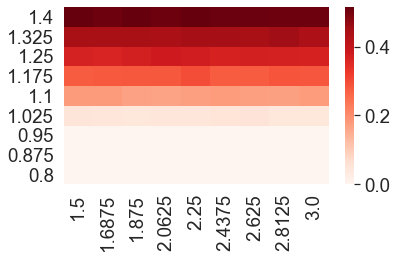

In [71]:
# Fig. 1A: plotting
to_plot = pd.pivot_table(fig1b_plot, values="frac", index="RT_int", columns="RT_fin")
sns.set(font_scale=1.7)
ax = sns.heatmap(to_plot, cmap="Reds")
ax.invert_yaxis()
plt.yticks(ticks=np.arange(len(to_plot.index))+0.5, labels=[round(x, 3) for x in to_plot.index])
plt.xticks()
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()
#plt.savefig(..., transparent=True)
plt.show()

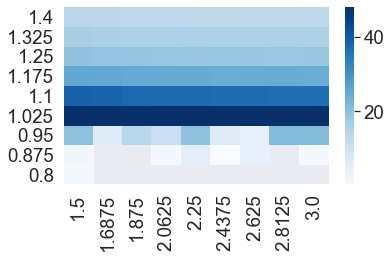

In [99]:
# Fig. 1B: plotting
to_plot = pd.pivot_table(fig1b_plot, values="time", index="RT_int", columns="RT_fin")
sns.set(font_scale=1.7)
ax = sns.heatmap(np.minimum(to_plot * 14/30, 48), cmap="Blues")
ax.invert_yaxis()
plt.yticks(ticks=np.arange(len(to_plot.index))+0.5, labels=[round(x, 3) for x in to_plot.index])
plt.xticks()
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()
#plt.savefig("./manuscript/raw_panels/RT_int_fin_sweep_time.eps", transparent=True)
plt.show()

In [4]:
# Simulations for Figs. 1C-D
num_trials = 1e4

mut_frac = []
avg_times = []
Rts = np.linspace(0.8, 1.4, num=9)
mut_nums = range(1,5)
Rt_plot = []
num_plot = []
for R_t in Rts:
    print(R_t)
    for num in mut_nums:
        Rt_plot.append(R_t)
        num_plot.append(num)
        
        muts = []
        times = []
        for i in range(int(num_trials)):
            mutated,time = simulate_bubbles(R_t, num, mut_rate=1e-5, reduce_RT=0, final_RT=2)
            muts.append(mutated)
            if mutated:
                times.append(time)
        mut_frac.append(np.sum(muts)/num_trials)
        if len(times) > 0:
            avg_times.append(np.mean(times))
        else:
            avg_times.append(np.nan)
            
fig1c_plot = pd.DataFrame({"RT_int": Rt_plot, "num_muts": num_plot, "time":avg_times, "frac":mut_frac})

0.8
0.875
0.95
1.025
1.1
1.1749999999999998
1.25
1.325
1.4


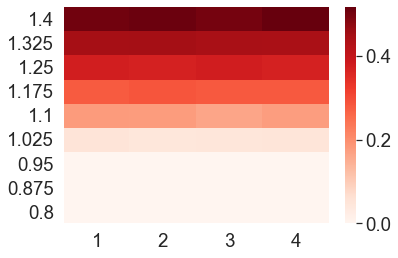

In [82]:
# Fig. 1C: plotting
to_plot = pd.pivot_table(fig1c_plot, values="frac", index="RT_int", columns="num_muts")
ax = sns.heatmap(to_plot, cmap="Reds")
ax.invert_yaxis()
sns.set(font_scale=1.7)
plt.yticks(ticks=np.arange(len(to_plot.index))+0.5, labels=[round(x, 3) for x in to_plot.index])
plt.xticks()
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()
#plt.savefig(..., transparent=True)
plt.show()

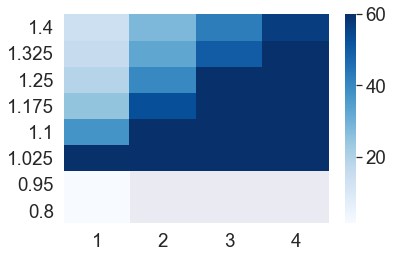

In [97]:
# Fig. 1D: plotting
to_plot = pd.pivot_table(fig1c_plot, values="time", index="RT_int", columns="num_muts")
ax = sns.heatmap(np.minimum(to_plot * 14/30, 60), cmap="Blues")
ax.invert_yaxis()
plt.yticks(ticks=np.arange(len(to_plot.index))+0.5, labels=[round(x, 3) for x in to_plot.index])
plt.xticks()
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()
#plt.savefig(..., transparent=True)
plt.show()

1.162
1.3943999999999999
1.6267999999999998
1.8592
2.0916
2.324
2.5564
2.7888
3.0212
3.2535999999999996
3.4859999999999998
3.7184
3.9508
4.1832
4.4156
4.648
1.0458
1.25496
1.46412
1.67328
1.8824400000000001
2.0916
2.3007600000000004
2.5099200000000006
2.7190800000000004
2.92824
3.1374000000000004
3.34656
3.5557200000000004
3.7648800000000002
3.9740400000000005
4.1832
0.9296000000000001
1.11552
1.3014400000000002
1.4873600000000002
1.67328
1.8592000000000002
2.0451200000000003
2.2310400000000006
2.4169600000000004
2.6028800000000003
2.7888
2.9747200000000005
3.160640000000001
3.34656
3.5324800000000005
3.7184000000000004
0.8133999999999999
0.9760799999999998
1.1387599999999998
1.30144
1.4641199999999999
1.6267999999999998
1.78948
1.9521600000000001
2.1148399999999996
2.2775199999999995
2.4402
2.60288
2.76556
2.9282399999999997
3.0909199999999997
3.2535999999999996
0.6971999999999999
0.8366399999999999
0.9760799999999998
1.1155199999999998
1.2549599999999999
1.3943999999999999
1.53383999

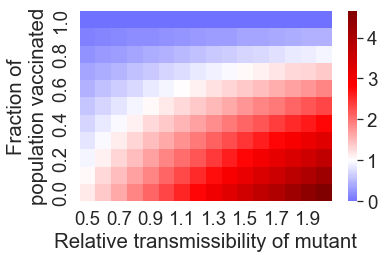

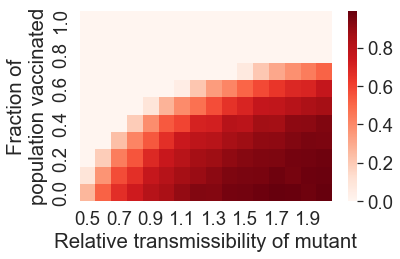

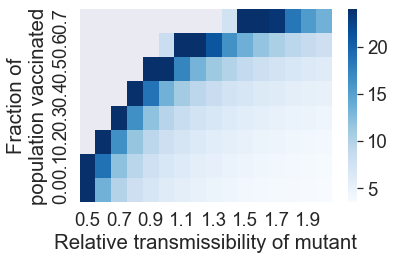

In [5]:
# Simulations and plotting for Fig. 2, 100% vaccine efficacy
R_0 = 3.32
e_v = 1
f_i = 0.3

f_vs = np.linspace(0, 1, num=11)
b_ms = np.linspace(0.5, 2, num=16)

mut_frac = []
avg_times = []
Rts = []
for f_v in f_vs:
    for b_m in b_ms:
        R_t = R_0 * (1 - f_v*e_v - f_i*(1-f_v)) * b_m
        print(R_t)
        Rts.append(R_t)
        num_trials = 1e3
        muts = []
        times = []
        for i in range(int(num_trials)):
            mutated,time = simulate_bubbles(R_t, 1, mut_rate=1e-5)
            muts.append(mutated)
            if mutated:
                times.append(time)
        mut_frac.append(np.sum(muts)/num_trials)
        if len(times) > 0:
            avg_times.append(np.mean(times))
        else:
            avg_times.append(np.nan)

# Fig. 2A: plotting
b_ms = [round(x,1) for x in b_ms]
f_vs = [round(x,1) for x in f_vs]
sns.set(font_scale=1.7)
sweep_df = pd.DataFrame({"f_v":np.repeat(f_vs, len(b_ms)), "b_m":np.tile(b_ms,len(f_vs)), "R_t":Rts, "mut":mut_frac, "time":avg_times})
to_plot = pd.pivot_table(sweep_df, values="R_t", index="f_v", columns="b_m")
ax = sns.heatmap(to_plot, center=1, cmap="seismic")
ax.invert_yaxis()
#plt.yticks(ticks=np.arange(len(to_plot.index))+0.5, labels=[round(x, 3) for x in to_plot.index])
#plt.xticks()
plt.ylabel("Fraction of\npopulation vaccinated")
plt.xlabel("Relative transmissibility of mutant")
plt.tight_layout()
#plt.savefig(..., transparent=True)
plt.show()

# Fig. 2B: plotting
b_ms = [round(x,1) for x in b_ms]
f_vs = [round(x,1) for x in f_vs]
to_plot = pd.pivot_table(sweep_df, values="mut", index="f_v", columns="b_m")
ax = sns.heatmap(to_plot, cmap="Reds")
ax.invert_yaxis()
#plt.yticks(ticks=np.arange(len(to_plot.index))+0.5, labels=[round(x, 3) for x in to_plot.index])
#plt.xticks()
plt.ylabel("Fraction of\npopulation vaccinated")
plt.xlabel("Relative transmissibility of mutant")
plt.tight_layout()
#plt.savefig(..., transparent=True)
plt.show()

# Fig. 2C: plotting
b_ms = [round(x,1) for x in b_ms]
f_vs = [round(x,1) for x in f_vs]
to_plot = pd.pivot_table(sweep_df, values="time", index="f_v", columns="b_m")
ax = sns.heatmap(np.minimum(to_plot * 14/30, 24), cmap="Blues")
ax.invert_yaxis()
#plt.yticks(ticks=np.arange(len(to_plot.index))+0.5, labels=[round(x, 3) for x in to_plot.index])
#plt.xticks()
plt.ylabel("Fraction of\npopulation vaccinated")
plt.xlabel("Relative transmissibility of mutant")
plt.tight_layout()
#plt.savefig(..., transparent=True)
plt.show()

1.162
1.3943999999999999
1.6267999999999998
1.8592
2.0916
2.324
2.5564
2.7888
3.0212
3.2535999999999996
3.4859999999999998
3.7184
3.9508
4.1832
4.4156
4.648
1.0956
1.3147199999999999
1.5338399999999999
1.7529599999999999
1.9720799999999998
2.1912
2.41032
2.62944
2.84856
3.0676799999999997
3.2867999999999995
3.5059199999999997
3.72504
3.9441599999999997
4.16328
4.3824
1.0292
1.23504
1.4408799999999997
1.64672
1.8525599999999998
2.0584
2.26424
2.4700800000000003
2.6759199999999996
2.8817599999999994
3.0875999999999997
3.29344
3.49928
3.7051199999999995
3.9109599999999998
4.1168
0.9628000000000001
1.1553600000000002
1.34792
1.5404800000000003
1.7330400000000001
1.9256000000000002
2.1181600000000005
2.3107200000000008
2.50328
2.69584
2.8884000000000003
3.0809600000000006
3.273520000000001
3.4660800000000003
3.6586400000000006
3.8512000000000004
0.8964
1.07568
1.2549599999999999
1.43424
1.61352
1.7928
1.97208
2.1513600000000004
2.33064
2.5099199999999997
2.6892
2.86848
3.0477600000000002
3.

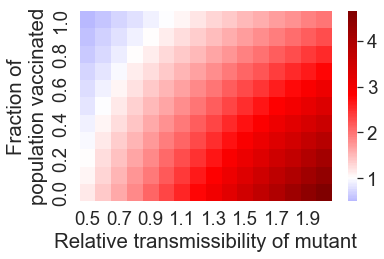

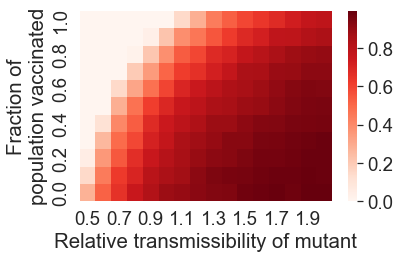

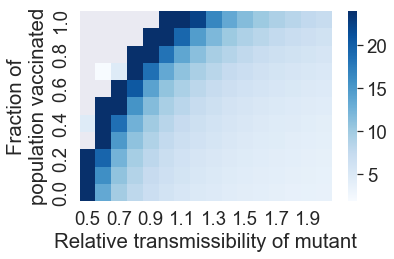

In [6]:
# Simulations and plotting for Fig. 2, 70% vaccine efficacy
R_0 = 3.32
e_v = 0.7
f_i = 0.3

f_vs = np.linspace(0, 1, num=11)
b_ms = np.linspace(0.5, 2, num=16)

mut_frac = []
avg_times = []
Rts = []
for f_v in f_vs:
    for b_m in b_ms:
        R_t = R_0 * (1 - f_v*e_v - f_i*(1-f_v)) * b_m
        print(R_t)
        Rts.append(R_t)
        num_trials = 1e3
        muts = []
        times = []
        for i in range(int(num_trials)):
            mutated,time = simulate_bubbles(R_t, 1, mut_rate=1e-5)
            muts.append(mutated)
            if mutated:
                times.append(time)
        mut_frac.append(np.sum(muts)/num_trials)
        if len(times) > 0:
            avg_times.append(np.mean(times))
        else:
            avg_times.append(np.nan)

# Fig. 2A: plotting
b_ms = [round(x,1) for x in b_ms]
f_vs = [round(x,1) for x in f_vs]
sns.set(font_scale=1.7)
sweep_df = pd.DataFrame({"f_v":np.repeat(f_vs, len(b_ms)), "b_m":np.tile(b_ms,len(f_vs)), "R_t":Rts, "mut":mut_frac, "time":avg_times})
to_plot = pd.pivot_table(sweep_df, values="R_t", index="f_v", columns="b_m")
ax = sns.heatmap(to_plot, center=1, cmap="seismic")
ax.invert_yaxis()
#plt.yticks(ticks=np.arange(len(to_plot.index))+0.5, labels=[round(x, 3) for x in to_plot.index])
#plt.xticks()
plt.ylabel("Fraction of\npopulation vaccinated")
plt.xlabel("Relative transmissibility of mutant")
plt.tight_layout()
#plt.savefig(..., transparent=True)
plt.show()

# Fig. 2B: plotting
b_ms = [round(x,1) for x in b_ms]
f_vs = [round(x,1) for x in f_vs]
to_plot = pd.pivot_table(sweep_df, values="mut", index="f_v", columns="b_m")
ax = sns.heatmap(to_plot, cmap="Reds")
ax.invert_yaxis()
#plt.yticks(ticks=np.arange(len(to_plot.index))+0.5, labels=[round(x, 3) for x in to_plot.index])
#plt.xticks()
plt.ylabel("Fraction of\npopulation vaccinated")
plt.xlabel("Relative transmissibility of mutant")
plt.tight_layout()
#plt.savefig(..., transparent=True)
plt.show()

# Fig. 2C: plotting
b_ms = [round(x,1) for x in b_ms]
f_vs = [round(x,1) for x in f_vs]
to_plot = pd.pivot_table(sweep_df, values="time", index="f_v", columns="b_m")
ax = sns.heatmap(np.minimum(to_plot * 14/30, 24), cmap="Blues")
ax.invert_yaxis()
#plt.yticks(ticks=np.arange(len(to_plot.index))+0.5, labels=[round(x, 3) for x in to_plot.index])
#plt.xticks()
plt.ylabel("Fraction of\npopulation vaccinated")
plt.xlabel("Relative transmissibility of mutant")
plt.tight_layout()
#plt.savefig(..., transparent=True)
plt.show()

1.162
1.3943999999999999
1.6267999999999998
1.8592
2.0916
2.324
2.5564
2.7888
3.0212
3.2535999999999996
3.4859999999999998
3.7184
3.9508
4.1832
4.4156
4.648
1.1287999999999998
1.3545599999999998
1.5803199999999997
1.8060799999999997
2.03184
2.2575999999999996
2.48336
2.70912
2.9348799999999997
3.1606399999999994
3.386399999999999
3.6121599999999994
3.8379199999999996
4.06368
4.28944
4.515199999999999
1.0956
1.3147199999999999
1.5338399999999999
1.7529599999999999
1.9720799999999998
2.1912
2.41032
2.62944
2.84856
3.0676799999999997
3.2867999999999995
3.5059199999999997
3.72504
3.9441599999999997
4.16328
4.3824
1.0624
1.27488
1.48736
1.69984
1.91232
2.1248
2.3372800000000002
2.5497600000000005
2.7622400000000003
2.97472
3.1872
3.39968
3.6121600000000003
3.82464
4.037120000000001
4.2496
1.0292000000000001
1.2350400000000001
1.4408800000000002
1.6467200000000002
1.8525600000000002
2.0584000000000002
2.2642400000000005
2.4700800000000007
2.6759200000000005
2.8817600000000003
3.0876
3.293440

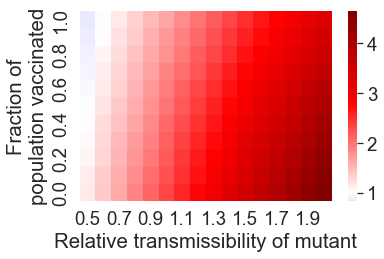

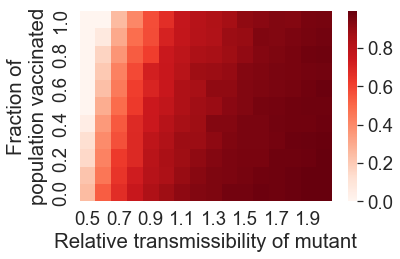

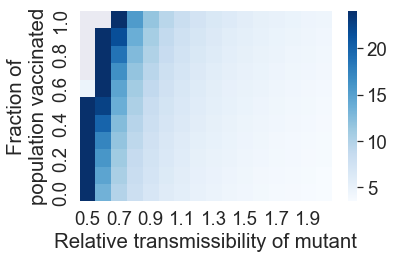

In [7]:
# Simulations and plotting for Fig. 2, 50% vaccine efficacy
R_0 = 3.32
e_v = 0.5
f_i = 0.3

f_vs = np.linspace(0, 1, num=11)
b_ms = np.linspace(0.5, 2, num=16)

mut_frac = []
avg_times = []
Rts = []
for f_v in f_vs:
    for b_m in b_ms:
        R_t = R_0 * (1 - f_v*e_v - f_i*(1-f_v)) * b_m
        print(R_t)
        Rts.append(R_t)
        num_trials = 1e3
        muts = []
        times = []
        for i in range(int(num_trials)):
            mutated,time = simulate_bubbles(R_t, 1, mut_rate=1e-5)
            muts.append(mutated)
            if mutated:
                times.append(time)
        mut_frac.append(np.sum(muts)/num_trials)
        if len(times) > 0:
            avg_times.append(np.mean(times))
        else:
            avg_times.append(np.nan)

# Fig. 2A: plotting
b_ms = [round(x,1) for x in b_ms]
f_vs = [round(x,1) for x in f_vs]
sns.set(font_scale=1.7)
sweep_df = pd.DataFrame({"f_v":np.repeat(f_vs, len(b_ms)), "b_m":np.tile(b_ms,len(f_vs)), "R_t":Rts, "mut":mut_frac, "time":avg_times})
to_plot = pd.pivot_table(sweep_df, values="R_t", index="f_v", columns="b_m")
ax = sns.heatmap(to_plot, center=1, cmap="seismic")
ax.invert_yaxis()
#plt.yticks(ticks=np.arange(len(to_plot.index))+0.5, labels=[round(x, 3) for x in to_plot.index])
#plt.xticks()
plt.ylabel("Fraction of\npopulation vaccinated")
plt.xlabel("Relative transmissibility of mutant")
plt.tight_layout()
#plt.savefig(..., transparent=True)
plt.show()

# Fig. 2B: plotting
b_ms = [round(x,1) for x in b_ms]
f_vs = [round(x,1) for x in f_vs]
to_plot = pd.pivot_table(sweep_df, values="mut", index="f_v", columns="b_m")
ax = sns.heatmap(to_plot, cmap="Reds")
ax.invert_yaxis()
#plt.yticks(ticks=np.arange(len(to_plot.index))+0.5, labels=[round(x, 3) for x in to_plot.index])
#plt.xticks()
plt.ylabel("Fraction of\npopulation vaccinated")
plt.xlabel("Relative transmissibility of mutant")
plt.tight_layout()
#plt.savefig(..., transparent=True)
plt.show()

# Fig. 2C: plotting
b_ms = [round(x,1) for x in b_ms]
f_vs = [round(x,1) for x in f_vs]
to_plot = pd.pivot_table(sweep_df, values="time", index="f_v", columns="b_m")
ax = sns.heatmap(np.minimum(to_plot * 14/30, 24), cmap="Blues")
ax.invert_yaxis()
#plt.yticks(ticks=np.arange(len(to_plot.index))+0.5, labels=[round(x, 3) for x in to_plot.index])
#plt.xticks()
plt.ylabel("Fraction of\npopulation vaccinated")
plt.xlabel("Relative transmissibility of mutant")
plt.tight_layout()
#plt.savefig(..., transparent=True)
plt.show()

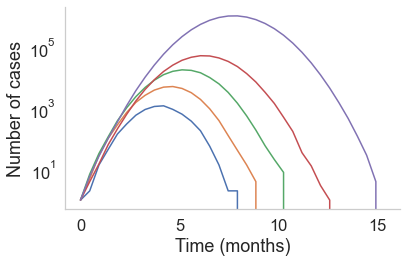

In [9]:
# Fig. 3A
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})

mut, end, time, to_plot = simulate_bubble(5, 1, 1e-20, -0.2, add_rate=0, return_all=True)
mut, end, time, to_plot2 = simulate_bubble(5, 1, 1e-20, -0.175, add_rate=0, return_all=True)
mut, end, time, to_plot3 = simulate_bubble(5, 1, 1e-20, -0.15, add_rate=0, return_all=True)
mut, end, time, to_plot4 = simulate_bubble(5, 1, 1e-20, -0.125, add_rate=0, return_all=True)
mut, end, time, to_plot5 = simulate_bubble(5, 1, 1e-20, -0.1, add_rate=0, return_all=True)

plt.figure()
plt.plot(np.arange(len(to_plot))*14/30, to_plot)
plt.plot(np.arange(len(to_plot2))*14/30, to_plot2)
plt.plot(np.arange(len(to_plot3))*14/30, to_plot3)
plt.plot(np.arange(len(to_plot4))*14/30, to_plot4)
plt.plot(np.arange(len(to_plot5))*14/30, to_plot5)
plt.yscale("log")
plt.xlabel("Time (months)")
plt.ylabel("Number of cases")
sns.despine()
plt.tight_layout()
#plt.savefig("./manuscript/raw_panels/bubble_sizes.eps", transparent=True)
plt.show()

In [3]:
# Fig. 3B: simulations
num_trials = 1e4

mut_frac = []
avg_times = []
Rts = np.linspace(1, 5, num=11)
reduce = -np.linspace(0, 0.2, num=11)
Rt_plot = []
reduce_plot = []
for R_t in Rts:
    print(R_t)
    for red in reduce:
        Rt_plot.append(R_t)
        reduce_plot.append(red)
        
        muts = []
        times = []
        for i in range(int(num_trials)):
            mutated,time = simulate_bubbles(R_t, 1, mut_rate=1e-5, reduce_RT=red, final_RT=2)
            muts.append(mutated)
            if mutated:
                times.append(time)
        mut_frac.append(np.sum(muts)/num_trials)
        if len(times) > 0:
            avg_times.append(np.mean(times))
        else:
            avg_times.append(np.nan)
            
fig3_plot = pd.DataFrame({"RT_int": Rt_plot, "reduce": reduce_plot, "time":avg_times, "frac":mut_frac})

1.0
1.4
1.8
2.2
2.6
3.0
3.4000000000000004
3.8000000000000003
4.2
4.6
5.0


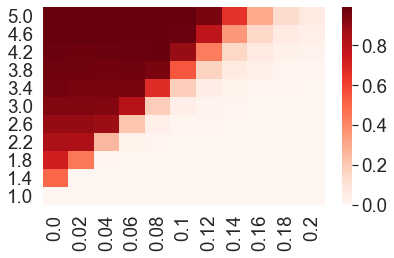

In [89]:
# Fig. 3B: plotting
fig3_plot = pd.DataFrame({"RT_int": Rt_plot, "reduce": -np.array(reduce_plot), "time":avg_times, "frac":mut_frac})
to_plot = pd.pivot_table(fig3_plot, values="frac", index="RT_int", columns="reduce")
ax = sns.heatmap(to_plot, cmap="Reds")
ax.invert_yaxis()
#ax.invert_xaxis()
plt.yticks(ticks=np.arange(len(to_plot.index))+0.5, labels=[round(x, 3) for x in to_plot.index])
#plt.xticks(ti)
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()
#plt.savefig(..., transparent=True)
plt.show()

In [4]:
# Functions to simulate vaccination and selection for Fig. 4
# Code from https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0258997

def SIR_vaccine(t, y, params):
    # compartments: S, I, R, I' (i.e., infected with variant), R', V
    # parameters: beta (infectiousness), beta_m (infectiousness of mutant), beta_c (infectiousness of mutant to immune), beta_v (infectiousness of mutant to vaccinated), rho (recovery rate), rho_m, v (vaccination rate), w (loss of immunity rate), w_v, vax_iff
    S, I, R, I_mut, R_mut, V = y
    beta, beta_m, beta_c, beta_v, rho, rho_m, v, w, w_v, vax_eff = params
    
    #vax_rate = min(S, v)
    dV = v*S - (w_v + I_mut*beta_v)*V - beta*I*(1-vax_eff)*V
    dS = -(beta*I + beta_m*I_mut + v)*S + w * (R + R_mut) + w_v*V
    dI = beta*I*(S + (1-vax_eff)*(V+R+R_mut)) - rho*I
    dR = rho*I - (w + beta_c*I_mut)*R - beta*I*(1-vax_eff)*R
    dI_mut = (beta_m*S + beta_c*R + beta_v*V - rho_m)*I_mut
    dR_mut = rho_m*I_mut - w*R_mut - beta*I*(1-vax_eff)*R_mut
    return(np.array([dS, dI, dR, dI_mut, dR_mut, dV]))

def simulate_evo_vaccine(init, params, t_span, mut_rate, pop_size):
    if mut_rate == 0:
        mut_emerge = np.inf
    else:
        mut_emerge = np.random.exponential(scale=1/mut_rate)
    t_return = np.arange(t_span[0], t_span[1])
    pre_mut = solve_ivp(lambda t,y: SIR_vaccine(t,y,params), t_span, init_cond, t_eval=t_return)
    new_case_numbers = total_pop_size*(params[0]*pre_mut.y[0,:]*pre_mut.y[1,:] + params[-1]*pre_mut.y[1,:]*(pre_mut.y[2,:] + pre_mut.y[4,:] + pre_mut.y[5,:]))
    mut_time = None
    total_new = 0
    for i in range(len(new_case_numbers)):
        total_new += new_case_numbers[i]
        if total_new > mut_emerge:
            mut_time = t_return[i]
            new_init = pre_mut.y[:,i]
            new_init[1] -= 1/pop_size
            new_init[3] += 1/pop_size
            new_time = t_return[i:]
            pre_t = pre_mut.t[:i]
            pre_y = pre_mut.y[:,:i]
            return((True, new_time))
    return((False, (pre_mut.t, pre_mut.y)))

In [6]:
# Fig. 4A: simulations

R0s = np.linspace(1, 5.7, num=21)
vaccine_rates = np.linspace(0, 0.02, num=21)

t_span = (0,365)
mutation_emerg_rate = 1e-5 #prob per new infection of new strain appearing
total_pop_size = 3e8

mut_perc = 0
vac_perc = 0
inf_perc = 1/total_pop_size
susc_perc = 1 - vac_perc - inf_perc
imm_perc = susc_perc * 0.3
susc_perc = susc_perc * 0.7
init_cond = np.array([susc_perc, inf_perc*(1-mut_perc), imm_perc, inf_perc*(mut_perc), 0, vac_perc])

num_iter = 1e3
plot_vax = []
plot_R0 = []
mutated = []
for R0_val in R0s:
    print(R0_val)
    for vax in vaccine_rates:
        trans = R0_val * 0.1
        params = [trans, 0, 0, 0, 0.1, 0.1, vax, 0.002, 0.002, 1]
        mut_counter = 0
        for i in range(int(num_iter)):
            has_mut, other = simulate_evo_vaccine(init_cond, params, t_span, mutation_emerg_rate, total_pop_size)
            mut_counter += has_mut
        plot_vax.append(vax)
        plot_R0.append(R0_val)
        mutated.append(mut_counter/num_iter)


1.0
1.235
1.47
1.705
1.94
2.175
2.41
2.645
2.88
3.115
3.35
3.585
3.8200000000000003
4.055
4.29
4.525
4.76
4.995
5.23
5.465
5.7


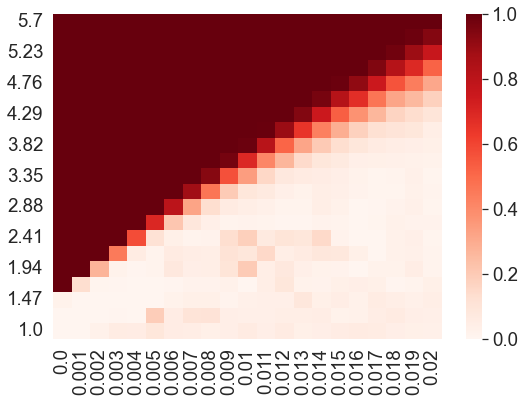

In [11]:
# Fig. 4A: plotting

sweep_df = pd.DataFrame({"R0":plot_R0, "vac_rate":plot_vax, "mut":mutated})

to_plot = pd.pivot_table(sweep_df, values="mut", index="R0", columns="vac_rate")

sns.set(rc={'figure.figsize':(8,6)})
sns.set(font_scale=1.7)
#ax = sns.heatmap(-to_plot, vmin=-1.2, vmax=0.8, cmap="RdGy")
ax = sns.heatmap(to_plot, cmap="Reds")
ax.invert_yaxis()
#ax.invert_xaxis()

ytick_list = to_plot.index[(np.arange(len(to_plot.index)) % 2 == 0)]
plt.yticks(ticks=2*np.arange(len(ytick_list))+0.5, labels=[round(x, 3) for x in ytick_list])
plt.xticks(ticks=np.arange(len(to_plot.columns))+0.5, labels=[round(x, 3) for x in to_plot.columns])
#plt.xticks(ti)
plt.ylabel("")
plt.xlabel("")
#plt.vlines(x=(1/365)*len(to_plot.columns), ymin = 0, ymax = len(to_plot.index))
plt.tight_layout()
#plt.savefig(..., transparent=True)
plt.show()

In [8]:
# Fig. B: simulations

R0s = np.linspace(1, 5.7, num=21)
vaccine_rates = np.linspace(0, 0.02, num=21)

t_span = (0,365)
mutation_emerg_rate = 1e-5 #prob per new infection of new strain appearing
total_pop_size = 3e8

mut_perc = 0
vac_perc = 0
inf_perc = 1/total_pop_size
susc_perc = 1 - vac_perc - inf_perc
imm_perc = susc_perc * 0.3
susc_perc = susc_perc * 0.7
init_cond = np.array([susc_perc, inf_perc*(1-mut_perc), imm_perc, inf_perc*(mut_perc), 0, vac_perc])

num_iter = 1e3
plot_vax = []
plot_R0 = []
mutated = []
for R0_val in R0s:
    print(R0_val)
    for vax in vaccine_rates:
        trans = R0_val * 0.1
        params = [trans, 0, 0, 0, 0.1, 0.1, vax, 0.002, 0.002, 0.7]
        mut_counter = 0
        for i in range(int(num_iter)):
            has_mut, other = simulate_evo_vaccine(init_cond, params, t_span, mutation_emerg_rate, total_pop_size)
            mut_counter += has_mut
        plot_vax.append(vax)
        plot_R0.append(R0_val)
        mutated.append(mut_counter/num_iter)

1.0
1.235
1.47
1.705
1.94
2.175
2.41
2.645
2.88
3.115
3.35
3.585
3.8200000000000003
4.055
4.29
4.525
4.76
4.995
5.23
5.465
5.7


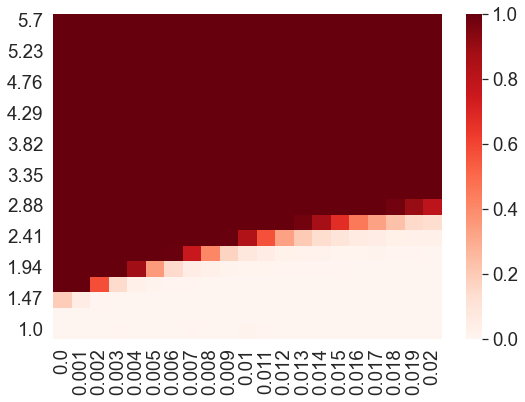

In [13]:
# Fig. 4B: plotting

sweep_df2 = pd.DataFrame({"R0":plot_R0, "vac_rate":plot_vax, "mut":mutated})

to_plot = pd.pivot_table(sweep_df2, values="mut", index="R0", columns="vac_rate")
ax = sns.heatmap(to_plot, cmap="Reds")
ax.invert_yaxis()
#ax.invert_xaxis()

ytick_list = to_plot.index[(np.arange(len(to_plot.index)) % 2 == 0)]
plt.yticks(ticks=2*np.arange(len(ytick_list))+0.5, labels=[round(x, 3) for x in ytick_list])

#plt.yticks(ticks=np.arange(len(to_plot.index))+0.5, labels=[round(x, 3) for x in to_plot.index])
#plt.xticks(ticks=np.arange(len(to_plot.columns))+0.5, labels=["{:.2e}".format(int(x*3e8)) for x in to_plot.columns])
plt.xticks(ticks=np.arange(len(to_plot.columns))+0.5, labels=[round(x, 3) for x in to_plot.columns])
#plt.xticks(ti)
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()
#plt.savefig(..., transparent=True)
plt.show()